<a href="https://colab.research.google.com/github/DaDamola/AI-Learning/blob/master/HW4_Problem3_Clas1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2020-04-22 03:33:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   111MB/s    in 0.6s    

2020-04-22 03:33:39 (111 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 23s 229ms/step - loss: 0.4438 - acc: 0.7820 - val_loss: 0.0346 - val_acc: 0.9630
Epoch 2/5
100/100 [==============================] - 19s 194ms/step - loss: 0.3675 - acc: 0.8300 - val_loss: 0.0543 - val_acc: 0.9650
Epoch 3/5
100/100 [==========================

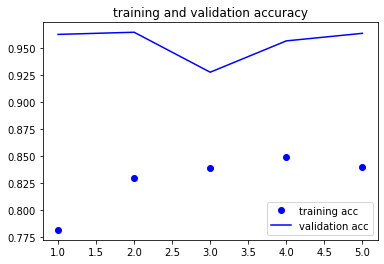

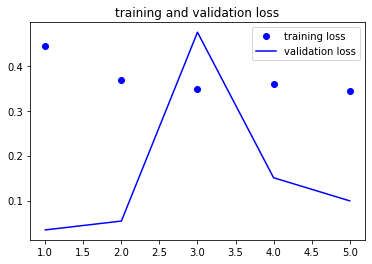

Validation loss: 0.0993356853723526
Validation accuracy: 0.9639999866485596
Epoch 1/5
100/100 [==============================] - 24s 236ms/step - loss: 0.3155 - acc: 0.8550 - val_loss: 0.1754 - val_acc: 0.9440
Epoch 2/5
100/100 [==============================] - 19s 195ms/step - loss: 0.2813 - acc: 0.8790 - val_loss: 0.6547 - val_acc: 0.9380
Epoch 3/5
100/100 [==============================] - 20s 195ms/step - loss: 0.2765 - acc: 0.8825 - val_loss: 0.1458 - val_acc: 0.9010
Epoch 4/5
100/100 [==============================] - 19s 194ms/step - loss: 0.3029 - acc: 0.8700 - val_loss: 0.0484 - val_acc: 0.9200
Epoch 5/5
100/100 [==============================] - 19s 194ms/step - loss: 0.2792 - acc: 0.8800 - val_loss: 0.0605 - val_acc: 0.9310


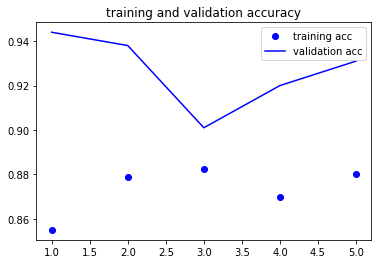

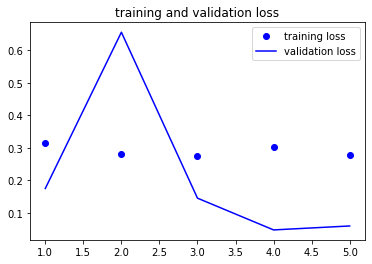

Validation loss: 0.4711500108242035
Validation accuracy: 0.9309999942779541


In [18]:
import os
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
from keras.applications import Xception
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#load convolutional base
conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

#freeze the convolutional base
conv_base.trainable = False

#concatenate the convolutional base and densely connected layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#train the model end to end with frozen convolutional base

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, #
    epochs=5, #30
    validation_data=validation_generator,
    validation_steps=50
)

conv_base.summary()

#display curves of loss and accuracy during training
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#print out validation loss and accuracy
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

#fine-tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block14_sepconv1' or layer.name == 'block14_sepconv2':
    set_trainable = True
  
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5, #100
    validation_data=validation_generator,
    validation_steps=50)

#display learning curves during fine-tuning
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

#print out validation loss and accuracy
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)
